In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import phate
from scipy.spatial import distance
import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.manifold import trustworthiness

os.chdir("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering")

from celldyn_qc import QcControl

%matplotlib inline


In [2]:

def sigmoid(x):
    #return np.tanh(x)
    return 1/(1+np.exp(-x))

def sigmoid_log(x):
    return sigmoid(np.log(x))

In [4]:
os.chdir("L:/lab_research/RES-Folder-UPOD/Celldynclustering")
celldyn = pd.read_sas("E_ResearchData/2_ResearchData/celldyn.sas7bdat")


D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


In [6]:
celldyn = celldyn.drop(['c_b_hgb_usa','c_b_mchc_usa','c_b_mch_Usa'],axis = 1)

In [7]:
meas_columns = [c for c in celldyn.columns if 'c_b' in c]
mode_columns = [c for c in celldyn.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn.columns if 'c_s_' in c.lower()]
celldyn = celldyn[meas_columns+mode_columns+alrt_columns+c_s_columns]
celldyn_full = celldyn[celldyn[meas_columns].isna().sum(axis=1)==0] # c_mode_cbc & c_mode_rtc are flagged

celldyn_full = QcControl.qc_rbc(celldyn_full)
celldyn_full = QcControl.qc_leuko(celldyn_full)
celldyn_full = QcControl.qc_standard_values(celldyn_full)

D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [8]:
cut_offs = pd.read_csv("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\CelldynParams.csv",delimiter=";",encoding = 'latin-1')
col_names = cut_offs.columns
cut_offs = pd.DataFrame(np.where(cut_offs == '-',np.nan,cut_offs),columns=col_names)
print(len(celldyn_full))
for c in meas_columns:
    try:
        min_val = float(cut_offs.loc[cut_offs.Kolomnaam == c,'Min'].iloc[0])
        max_val = float(cut_offs.loc[cut_offs.Kolomnaam == c,'Max'].iloc[0])
        if c == 'c_b_ht':
            min_val*=100
            max_val*=100
        if not pd.isna(min_val):
            celldyn_full = celldyn_full.loc[lambda x:(x[c] <= max_val) & (x[c] >= min_val)]
            print(c, len(celldyn_full))
    except IndexError:
        print(c)



print(len(celldyn_full))

1990361
c_b_wbc 1990357
c_b_neu 1990306
c_b_seg 1990306
c_b_bnd 1990306
c_b_ig 1990306
c_b_lym 1990306
c_b_vlym 1990306
c_b_mon 1990302
c_b_blst 1990302
c_b_eos 1990302
c_b_bas 1990302
c_b_nrbc 1990180
c_b_pneu 1990180
c_b_pseg 1990180
c_b_pbnd 1990180
c_b_pig 1990180
c_b_plym 1990180
c_b_pvlym 1990180
c_b_pmon 1988863
c_b_pblst 1988863
c_b_peos 1988821
c_b_pbas 1988821
c_b_pnrbc 1986264
c_b_rbci 1986264
c_b_rbco 1986166
c_b_mcv 1986150
c_b_rdw 1986140
c_b_pMIC 1986140
c_b_pMAC 1986140
c_b_ht 1974468
c_b_plto 1974420
c_b_plti 1974406
c_b_mpv 1973210
c_b_retc 1972022
c_b_rtcfmn
c_b_rtcfcv
c_b_hb 1971913
c_b_mch 1971913
c_b_mchc 1971913
1971913


### Alerts

In [3]:
celldyn_full = celldyn_full.loc[~np.any(celldyn_full[c_s_columns].isin([4,5]),axis = 1)]

NameError: name 'celldyn_full' is not defined

In [10]:
celldyn_full.to_csv("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\Data\data_no_c_s_45.csv")

# cleaned data


Removed alerts = 4 and 5

In [3]:
celldyn_full = pd.read_csv("L:/laupodteam/AIOS/Huibert-Jan/Celldynclustering/Data/data_no_c_s_45.csv")

In [4]:
meas_columns = [c for c in celldyn_full.columns if 'c_b' in c]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=len(meas_columns)//3 + 1, figsize=(18, 5*(len(meas_columns)//3  + 1)),facecolor='white')
i = 0
j = 0

for col in meas_columns:
    ax[j][i].hist(celldyn_full[col],bins = 200)
    ax[j][i].set_xlabel(col)

    j = j + 1 if i == 2 else j
    i = i + 1 if i < 2 else 0

plt.savefig('distributions_meas_cols.png',dpi = 300,box_inches='tight')

## define preprocessing and Pipeline

In [6]:
droplist = ['c_b_wvf', 'c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']
sl_list = ['c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst','c_b_mone','c_b_mon','c_b_bas',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']
log_list = ['c_b_wbc','c_b_neu','c_b_seg','c_b_lym','c_b_eos',]

final_columns = list(set(meas_columns)-set(droplist))


q_scaler = FunctionTransformer(func=lambda x: np.maximum(np.quantile(x,0.001), np.minimum(np.quantile(x, 0.999), x)))
sl_scaler = FunctionTransformer(func=sigmoid_log)
wvf_scaler = FunctionTransformer(func=lambda x: np.maximum(0.90,(np.minimum(1, x))))
log_scaler = FunctionTransformer(func=lambda x: np.log(x+1))

transformer_list = [('wvf_scaler', wvf_scaler, ['c_b_wvf']),
                    ('q_scaler', q_scaler, final_columns),
                    ('sl_scaler', sl_scaler, sl_list),
                    ('log_scaler',log_scaler, log_list)]

pre_transformer = ColumnTransformer(transformer_list,remainder = 'passthrough')

embedder_full = phate.PHATE(n_components = 10, knn = 15,n_jobs = -3,decay = 20, gamma = 0,
                            n_pca = 15, mds_solver='smacof',knn_dist='cityblock',mds_dist='cityblock',)
le_pipe = Pipeline([('scaler_1', pre_transformer),                    
                    ('scaler_2', StandardScaler())])



In [15]:
with open("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\sample_indices.txt",'r') as f:
    samples = [int(x) for x in f.read().split("\n")[:-1]]

In [7]:
sample_df = celldyn_full.sample(50000)
print(len(sample_df))
reduce_dim = 10


50000


## train embedder

In [6]:
transformed_data = le_pipe.fit_transform(sample_df[meas_columns]) # final_columns

transformed_data = embedder_full.fit_transform(transformed_data)


50000
Calculating PHATE...
  Running PHATE on 50000 observations and 88 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.34 seconds.
    Calculating KNN search...
    Calculated KNN search in 42.46 seconds.
    Calculating affinities...
    Calculated affinities in 2.03 seconds.
  Calculated graph and diffusion operator in 45.20 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 13.94 seconds.
    Calculating KMeans...
    Calculated KMeans in 40.46 seconds.
  Calculated landmark operator in 57.12 seconds.
  Calculating optimal t...
    Automatically selected t = 13
  Calculated optimal t in 3.48 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.73 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 383.46 seconds.
Calculated PHATE in 490.05 seconds.


## check embedder

Calculating KNN search...


c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\phate\phate.py:898: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 0.45 seconds.
Calculating affinities...
Calculated affinities in 0.03 seconds.


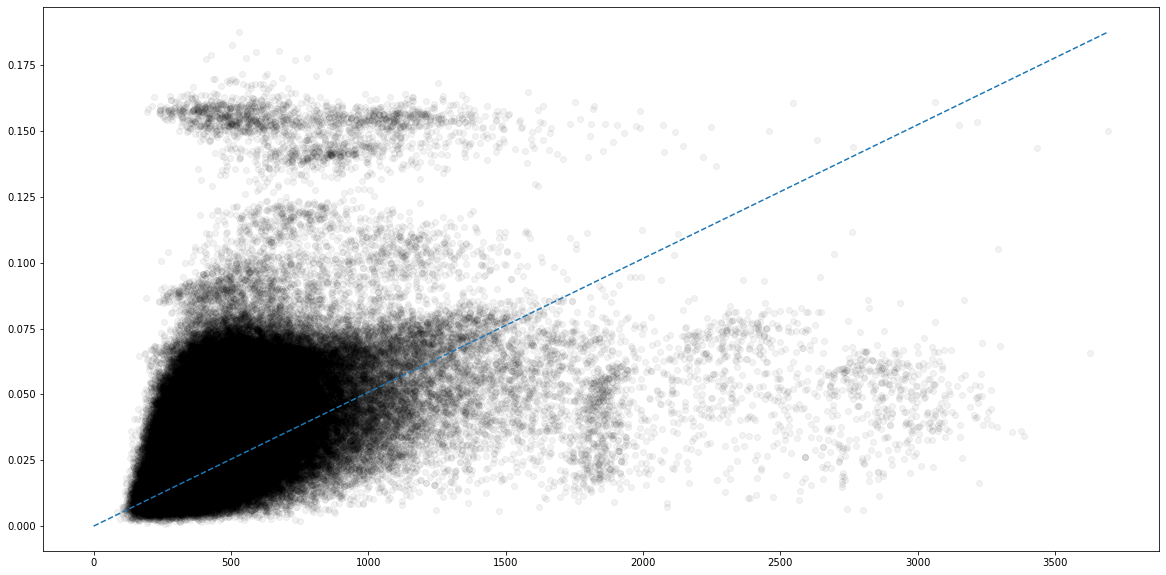

In [7]:
sample_selection = np.random.randint(0,100000,1000)

dist_df = sample_df.reset_index(drop = True)[meas_columns].loc[lambda x:x.index.isin(sample_selection)]

dist_before = distance.pdist(dist_df,metric='cityblock')
dist_after = distance.pdist(embedder_full.transform(le_pipe.transform(dist_df)),metric = 'cityblock')


plt.figure(figsize = (20,10))
plt.scatter(dist_before,dist_after, alpha = 0.05,c ='black')
mx,my = max(dist_before), max(dist_after)
plt.plot([0,mx],[0,my],ls = "--")

In [8]:
clusterer_embedding = KMeans(n_clusters = 5)
clusterer_embedding.fit(transformed_data)

KMeans(n_clusters=5)

In [9]:
clusterer_org_dat = KMeans(n_clusters = 5)
clusterer_org_dat.fit(StandardScaler().fit_transform(pre_transformer.fit_transform(sample_df[meas_columns])))

KMeans(n_clusters=5)

In [10]:
r_score =rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
ar_score = adjusted_rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
mi_score = adjusted_mutual_info_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)

In [11]:
ch_score1 = calinski_harabasz_score(sample_df[meas_columns], clusterer_org_dat.labels_)
ch_score2 = calinski_harabasz_score(transformed_data, clusterer_embedding.labels_)

db_score1 = davies_bouldin_score(sample_df[meas_columns], clusterer_org_dat.labels_)
db_score2 = davies_bouldin_score(transformed_data, clusterer_embedding.labels_)

In [12]:
dist_preservation_overall = dcor.distance_correlation(dist_before, dist_after)

In [13]:
print("Distance preservation overall", dist_preservation_overall)
print("Intra-distance trustworthiness", trustworthiness(sample_df[meas_columns], transformed_data))
print("Rand score", r_score)
print("Adjusted Rand score", ar_score)
print("Adjusted MI score", mi_score)
print("Calinski-Harabasz ratio, lower than 1 means better clustering for embedding", ch_score1/ch_score2)
print("David-Bouldin ratio, higher than 1 means better clustering for embedding", db_score1/db_score2)

Distance preservation overall 0.41092052292392134
Intra-distance trustworthiness 1.0696631821091374
Rand score 0.7847956207124143
Adjusted Rand score 0.4818700278130126
Adjusted MI score 0.46786882533744617
Calinski-Harabasz ratio, lower than 1 means better clustering for embedding 0.0858764328462339
David-Bouldin ratio, higher than 1 means better clustering for embedding 3.851329699050879


In [14]:
plot_df = pd.DataFrame(data=transformed_data, columns=[f'd_{i}' for i in range(10)], index=sample_df.index)
plot_df = plot_df.join(sample_df[mode_columns+alrt_columns+c_s_columns])
plot_df['k_means']  = clusterer_embedding.labels_
plot_df['has_alrt'] = np.where(np.sum(plot_df[alrt_columns],axis = 1) >0.5,1,0)
#reduce_dim = min([6, reduce_dim])
num_rows = int(np.ceil(10**2/3))


### preliminary clustering

In [15]:
from hdbscan import HDBSCAN

db_scan = HDBSCAN(min_samples= 50)
plot_df['HDBSCAN'] = db_scan.fit_predict(plot_df[[f'd_{i}' for i in range(reduce_dim)]])


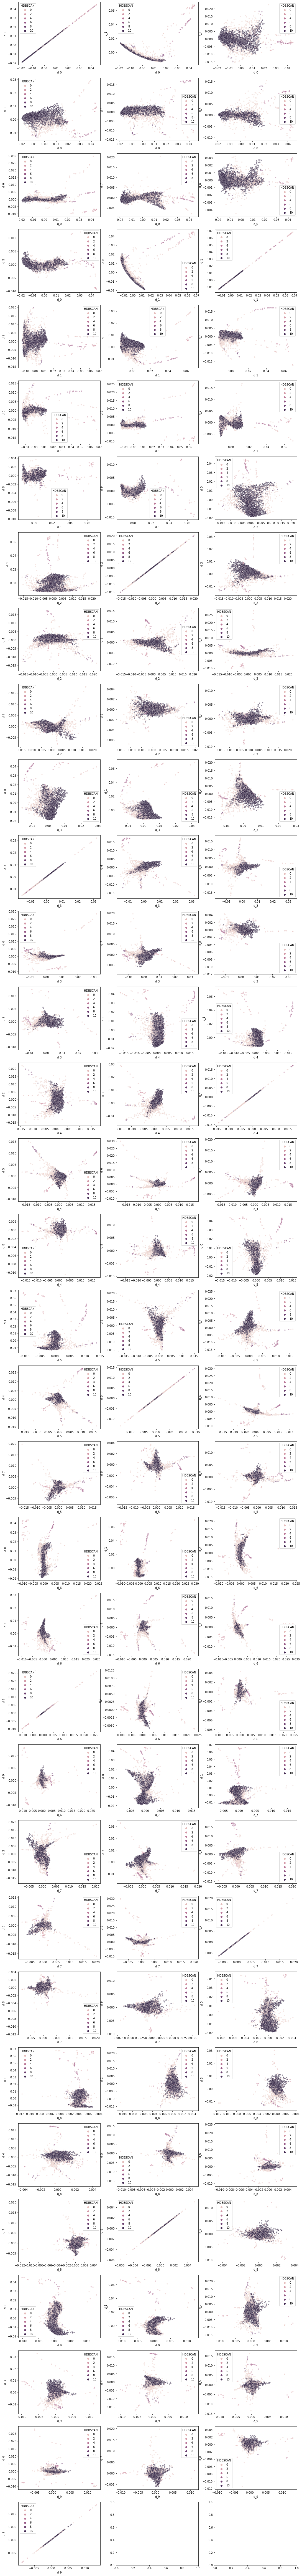

In [16]:
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 5*num_rows))
k = 0
for ki in range(reduce_dim):
    for kj in range(reduce_dim): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[i,j], 
                            hue='HDBSCAN', alpha=0.5, s = 20)
        else:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[k], 
                            hue='HDBSCAN', alpha=0.5, s = 20)
        k += 1



## use pretrained HDBScan model


model is trained on all data, see how the other way around works

In [10]:
import joblib 


clusterer = joblib.load("Notebooks/hdbscan_model.pkl")

transformed_data = le_pipe.fit_transform(celldyn_full[meas_columns]) # final_columns

transformed_data = embedder_full.fit_transform(transformed_data)

Calculating PHATE...
  Running PHATE on 1591560 observations and 88 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 11.71 seconds.
    Calculating KNN search...


In [ ]:
plt.style.use('seaborn-paper')
num_rows = int(np.ceil(10**2/3))
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 5*num_rows))
k = 0
plot_data = np.random.choice(transformed_data.shape[0], size=10000, replace=False)
for ki in range(reduce_dim):
    for kj in range(reduce_dim): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            ax[i,j].scatter(transformed_data[plot_data,ki],transformed_data[plot_data,kj], alpha=0.5,s = 3,c = clusterer.labels_.astype(float)[plot_data])
        else:
            ax[k].scatter(transformed_data[plot_data,ki],transformed_data[plot_data,kj], alpha=0.5)
        k += 1
